<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/02_dnn_simple_pytorch/10_MNIST_CNN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNによる画像認識（MNIST, PyTorch実装）


---
## 目的
PyTorch実装による畳み込みニューラルネットワーク（CNN）を用いてMNISTデータセットに対する文字認識を行う．
評価はConfusion Matrixにより各クラスの認識率を用いて行う．

また，GPUを用いたネットワークの計算を行う．

## 準備

### Google Colaboratoryの設定確認・変更
本チュートリアルではPyTorchを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**

## モジュールのインポート
はじめに必要なモジュールをインポートする．

In [1]:
from time import time
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import torchsummary

### GPUの確認
GPUを使用した計算が可能かどうかを確認します．

`Use CUDA: True`と表示されれば，GPUを使用した計算をPyTorchで行うことが可能です．
Falseとなっている場合は，上記の「Google Colaboratoryの設定確認・変更」に記載している手順にしたがって，設定を変更した後に，モジュールのインポートから始めてください．

In [2]:
use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)

Use CUDA: True


## データセットの読み込みと確認
学習データ（MNIST Dataset）を読み込みます．

In [3]:
train_data = torchvision.datasets.MNIST(root="./", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST(root="./", train=False, transform=transforms.ToTensor(), download=True)

print(type(train_data.data), type(train_data.targets))
print(type(test_data.data), type(test_data.targets))
print(train_data.data.size(), train_data.targets.size())
print(test_data.data.size(), test_data.targets.size())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([10000, 28, 28]) torch.Size([10000])


## ネットワークモデルの定義

畳み込みニューラルネットワークを定義します．

ここでは，畳み込み層２層，全結合層３層から構成されるネットワークとします．

1層目の畳み込み層は入力チャンネル数が1，出力する特徴マップ数が16，畳み込むフィルタサイズが3x3です．
2層目の畳み込み層は入力チャネル数が16．出力する特徴マップ数が32，畳み込むフィルタサイズは同じく3x3です．
１つ目の全結合層は入力ユニット数は`7*7*32`とし，出力は1024としています．
次の全結合層入力，出力共に1024，出力層は入力が1024，出力が10です．
また，活性化関数として`self.act`にシグモイド関数を定義します．
さらに，プーリング処理を行うための`self.pool`を定義します．
ここでは，maxpoolingを使用します．
これらの各層の構成を`__init__`関数で定義します．

次に，`forward`関数では，定義した層を接続して処理するように記述します．
`forward`関数の引数`x`は入力データです．
それを`__init__`関数で定義した`conv1`に入力し，その出力を活性化関数である`self.act`に与えます．
そして，その出力を`self.pool`に与えて，プーリング処理結果を`h`として出力します．
2層目の畳み込み層でも同様の手順で処理を行います．

畳み込みを適用した後の特徴マップを全結合層へと入力して，識別結果を出力します．
まず．畳み込みによって得られた特徴マップの形状（チャンネルx縦x横）を1次元の配列へと変換します．
ここで，`view()`を用いることで，`h`の配列を操作します．引数として，変換したい配列のサイズを入力します．
まず一つ目の引数の`h.size()[0]`で，`h`の1次元目のサイズを取得し，変換後の配列の1次元目のサイズとして指定します．
二つ目の引数の`-1`で任意のサイズを指定します．
これにより，`h`を（バッチ数x任意の長さのデータ）の形状へ変換します．
変換した`h`を全結合層および活性化関数へと順次入力することで，最終的にクラススコアを返します．

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.l1 = nn.Linear(7*7*32, 1024)
        self.l2 = nn.Linear(1024, 1024)
        self.l3 = nn.Linear(1024, 10)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        h = self.pool(self.act(self.conv1(x)))
        h = self.pool(self.act(self.conv2(h)))
        h = h.view(h.size()[0], -1)
        h = self.act(self.l1(h))
        h = self.act(self.l2(h))
        h = self.l3(h)
        return h

## ネットワークの作成
上のプログラムで定義したネットワークを作成します．

`CNN`クラスを呼び出して，ネットワークモデルを定義します．
また，GPUを使う場合（`use_cuda == True`）には，ネットワークモデルをGPUメモリ上に配置します．
これにより，GPUを用いた演算が可能となります．

学習を行う際の最適化方法としてモーメンタムSGD(モーメンタム付き確率的勾配降下法）を利用します．
また，学習率を0.01，モーメンタムを0.9として引数に与えます．

最後に，定義したネットワークの詳細情報を`torchsummary.summary()`関数を用いて表示します．

In [5]:
model = CNN()
if use_cuda:
    model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# モデルの情報を表示
if use_cuda:
    torchsummary.summary(model, (1, 28, 28), device='cuda')
else:
    torchsummary.summary(model, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                 [-1, 1024]       1,606,656
              ReLU-8                 [-1, 1024]               0
            Linear-9                 [-1, 1024]       1,049,600
             ReLU-10                 [-1, 1024]               0
           Linear-11                   [-1, 10]          10,250
Total params: 2,671,306
Trainable params: 2,671,306
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

## 学習
読み込んだMNISTデータセットと作成したネットワークを用いて，学習を行います．

1回の誤差を算出するデータ数（ミニバッチサイズ）を100，学習エポック数を10とします．

次にデータローダーを定義します．
データローダーでは，上で読み込んだデータセット（`train_data`）を用いて，for文で指定したミニバッチサイズでデータを読み込むオブジェクトを作成します．
この時，`shuffle=True`と設定することで，読み込むデータを毎回ランダムに指定します．

次に，誤差関数を設定します．
今回は，分類問題をあつかうため，クロスエントロピー誤差を計算するための`CrossEntropyLoss`を`criterion`として定義します．

学習を開始します．

各更新において，学習用データと教師データをそれぞれ`image`と`label`とします．
学習モデルにimageを与えて各クラスの確率yを取得します．
各クラスの確率yと教師ラベルtとの誤差を`criterion`で算出します．
また，認識精度も算出します．
そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．

In [6]:
# ミニバッチサイズ・エポック数の設定
batch_size = 100
epoch_num = 10

# データローダーの設定
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 誤差関数の設定
criterion = nn.CrossEntropyLoss()
if use_cuda:
    criterion.cuda()

# ネットワークを学習モードへ変更
model.train()

# 学習の実行
train_start = time()
for epoch in range(1, epoch_num+1):
    sum_loss = 0.0
    count = 0

    for image, label in train_loader:

        if use_cuda:
            image = image.cuda()
            label = label.cuda()

        y = model(image)

        loss = criterion(y, label)
        model.zero_grad()
        loss.backward()
        optimizer.step()

        sum_loss += loss.item()

        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

    print("epoch: {}, mean loss: {}, mean accuracy: {}, elapsed time: {}".format(epoch, sum_loss/600, count.item()/60000., time() - train_start))

epoch: 1, mean loss: 0.6551687675341964, mean accuracy: 0.79395, elapsed time: 6.8982157707214355
epoch: 2, mean loss: 0.10085071415795634, mean accuracy: 0.9689166666666666, elapsed time: 13.421484231948853
epoch: 3, mean loss: 0.06354043823472845, mean accuracy: 0.9799, elapsed time: 21.769153356552124
epoch: 4, mean loss: 0.04806918042595498, mean accuracy: 0.9848333333333333, elapsed time: 28.395676851272583
epoch: 5, mean loss: 0.037400193905535464, mean accuracy: 0.9888166666666667, elapsed time: 34.98210144042969
epoch: 6, mean loss: 0.03161057881390055, mean accuracy: 0.9899666666666667, elapsed time: 41.57380390167236
epoch: 7, mean loss: 0.025953599309529334, mean accuracy: 0.9917666666666667, elapsed time: 48.14356827735901
epoch: 8, mean loss: 0.020623703791255443, mean accuracy: 0.9933833333333333, elapsed time: 54.676724433898926
epoch: 9, mean loss: 0.017816195130629542, mean accuracy: 0.9944166666666666, elapsed time: 61.310951471328735
epoch: 10, mean loss: 0.015233061

## テスト

学習したネットワークを用いて，テストデータに対する認識率の確認を行います．

`model.eval()`を適用することで，ネットワーク演算を評価モードへ変更します．
これにより，学習時と評価時で挙動が異なる演算（dropout等）を変更することが可能です．
また，`torch.no_grad()`を適用することで，学習時には必要になる勾配情報を保持することなく演算を行います．

In [7]:
# データローダーの準備
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)

# ネットワークを評価モードへ変更
model.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for image, label in test_loader:

        if use_cuda:
            image = image.cuda()
            label = label.cuda()
            
        y = model(image)

        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

print("test accuracy: {}".format(count.item() / 10000.))

test accuracy: 0.9885


## 課題


### 1. GPUを用いた場合とCPUを用いた場合の学習での計算時間の違いを確認しましょう．

**ヒント**

GPUとCPUの切り替えは「GPUの確認」というセル（本ページ上部）にある`use_cuda`の`True`, `False`を変更することで，切り替えが可能です．


### 2. ネットワークの構造を変更し，認識精度の変化を確認しましょう．

**ヒント：ネットワーク構造の変更としては，次のようなものが考えられます．**
* 中間層のユニット数
* 層の数
* 活性化関数
  * `nn.Tanh()`や`nn.ReLU()`, `nn.LeakyReLU()`などが考えられます．
  * その他のPyTorchで使用できる活性化関数は[こちらページ](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)にまとめられています．

※ ネットワーク構造を変更した際には，`torchsummary.summary(***)`を使用し，ネットワーク構造を変更した際のパラメータ数の変化を確認してみましょう．


### 3. 学習の設定を変更し，認識精度の変化を確認しましょう．

**ヒント：プログラムの中で変更で切る設定は次のようなものが存在します．**
* ミニバッチサイズ
* 学習回数（Epoch数）
* 学習率
* 最適化手法
  * `torch.optim.Adagrad()`や`torch.optim.Adam()`などが考えられます．
  * PyTorchで使用できる最適化手法は[こちらのページ](https://pytorch.org/docs/stable/optim.html#algorithms)にまとめられています．



# 独自の画像データを用いた推論
学習は前述の「CNNによる画像認識（MNIST,Pytorch実装）」で実行してください。

前述で学習を行ったモデルを用いて、独自の画像データを用いて推論を行います。

## Google Driveの同期
"Mounted at /content/drive"と表示されれば、正常にマウントできています．

現在接続しているサーバ内の/content/driveに自身のGoogle Drive（マイドライブ）をマウントしています．


In [8]:
from google.colab import drive
drive_path = '/content/drive'
drive.mount(drive_path)

Mounted at /content/drive


## モジュールのインポート

In [9]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

import torchsummary
import os
from PIL import Image
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)

Use CUDA: True


## 独自の画像データの読み込み
Google Driveのマイドライブに推論させたい画像をアップロードしておきます。

ori_pathにアップロードした画像のパスを記述します。画像が表示されれば読み込み成功です。

test image path: /content/drive/MyDrive/sample.png


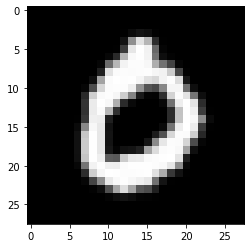

In [19]:
ori_path = "MyDrive/sample.png"

ori_path = os.path.join(drive_path, ori_path)
print("test image path: {}".format(ori_path))

ori_image = Image.open(ori_path).convert('L').resize((28, 28))
plt.imshow(ori_image, cmap='gray')
plt.show()

transform = transforms.Compose([transforms.ToTensor()])
image = transform(ori_image).unsqueeze(0)

## 独自データでの推論

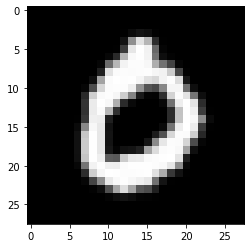

pred label: 0


In [20]:
# ネットワークを評価モードへ変更
model.eval()

# 推論の実行
with torch.no_grad():
  if use_cuda:
    image = image.cuda()
    
  y = model(image)
  pred = torch.argmax(y, dim=1)

plt.imshow(ori_image, cmap='gray')
plt.show()

print("pred label: {}".format(pred.item()))